# Applying pulse forcing in a Navier-Stokes problem

In [1]:
using ViscousFlow

┌ Info: Precompiling ViscousFlow [103da179-b3e4-57c1-99a4-586354eb2c5a]
└ @ Base loading.jl:1260


In [2]:
using Plots

In [3]:
Re = 200
xlim, ylim = (-2,2), (-2,4)
Δx,Δt = setstepsizes(Re,gridRe=4)

(0.02, 0.01)

In [4]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt)

Navier-Stokes system on a grid of size 208 x 308

In [5]:
w₀ = Nodes(Dual,size(sys))
nothing

Here is a basic pulse function: an asymmetric Gaussian distribution of force in the y direction

In [177]:
σx = 0.5
σy = 0.1
gauss = SpatialGaussian(σx,σy,0,0,1)
gaussfield = GeneratedField(Edges(Primal,size(sys)),EmptySpatialField(),gauss,sys.grid);
pulse = PulseField(gaussfield,0.1,0.1);

Here is another possibility, distributing the forcing in more complex form

In [178]:
gaussdist = EmptySpatialField()
n = 9
for x in range(-1,1,length=n)
    gaussdist += SpatialGaussian(0.4,0.1,x,0,50(1-abs(x))/n)
end
gaussfield = GeneratedField(Edges(Primal,size(sys)),EmptySpatialField(),gaussdist,sys.grid);
pulse = PulseField(gaussfield,0.1,0.1);

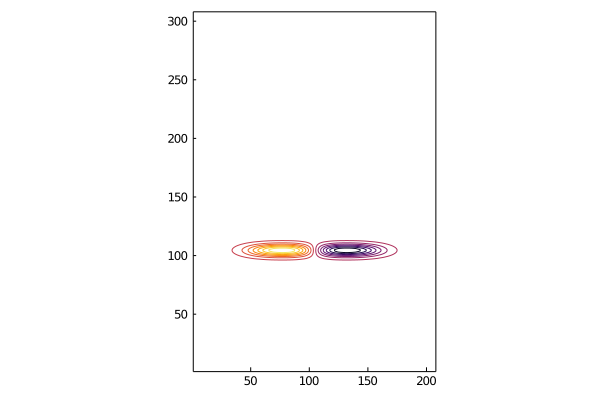

In [179]:
plot(curl(pulse(0.1)))

In [180]:
plan_intfact(t,w) = CartesianGrids.plan_intfact(t,w,sys)
r₁(w,t) = ConstrainedSystems.r₁(w,t,sys) + curl(pulse(t))

r₁ (generic function with 1 method)

In [181]:
solver = IFRK(w₀,timestep(sys),plan_intfact,r₁,rk=ConstrainedSystems.RK31)

Order-3 IF-RK integator with
   State of type Nodes{Dual,208,308,Float64,Array{Float64,2}}
   Time step size 0.01


In [182]:
# Initialize the fields
t = 0.0
w = zero(w₀)

# Rate at which to store field data
tsample = 1.0

# Field data storage plan
S = StorePlan(tsample,"state"=>w,"time"=>t)
data_history = initialize_storage(S);

store_data!(data_history,t,S,"state" => w, "time" => t);

In [183]:
tf = 5
@time for ti in timerange(tf,sys)
    global t, w = solver(t,w)
    
    store_data!(data_history,t,S,"state" => w, "time" => t)
end

 21.914865 seconds (436.41 k allocations: 13.833 GiB, 7.03% gc time)


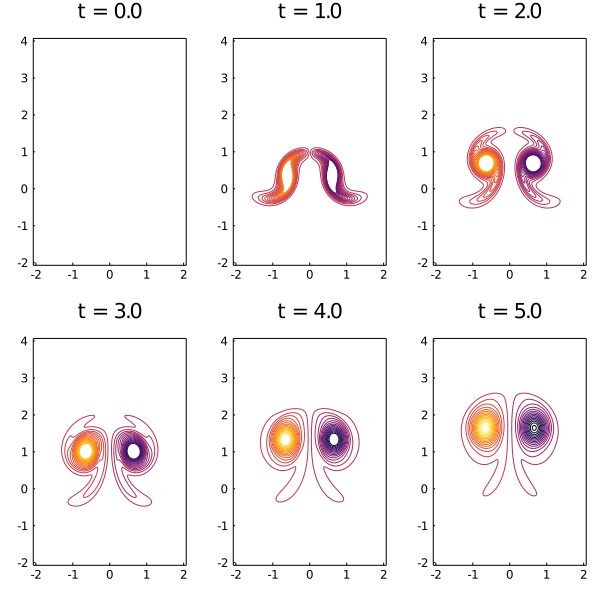

In [185]:
plt = plot(layout = (2,3), size = (600, 600), legend=:false)

for i in 1:6
    ts = string("t = ",round(data_history["time"][end-6+i],digits=3))
    plot!(plt[i],vorticity(data_history["state"][end-6+i],sys),sys,levels=range(-5,5,length=30),title=ts)
end
plt

### Create a point force

In [9]:
x0 = [1.5,0.0]
f0 = 10.0
t0 = 4
σt = 1
pulse = PointForce(w₀,x0,f0,t0,σt,sys)

Transient point force applied on the Nodes{Dual,208,308,Float64,Array{Float64,2}} field.
   strength = 10.0
   location = [1.5, 0.0]
   central time = 4.0
   half-interval = 1.0


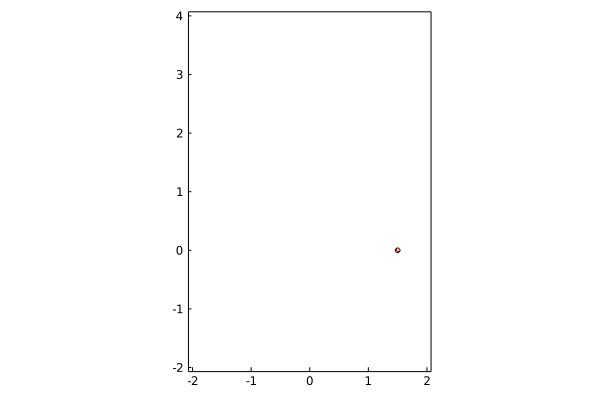

In [12]:
plot(pulse(4),sys)